# Demo: Smart Buildings with Azure and Control-M


https://github.com/controlm/automation-api-community-solutions/tree/master/1-general-examples/use-case-azure-smart-building
[link text](https://)


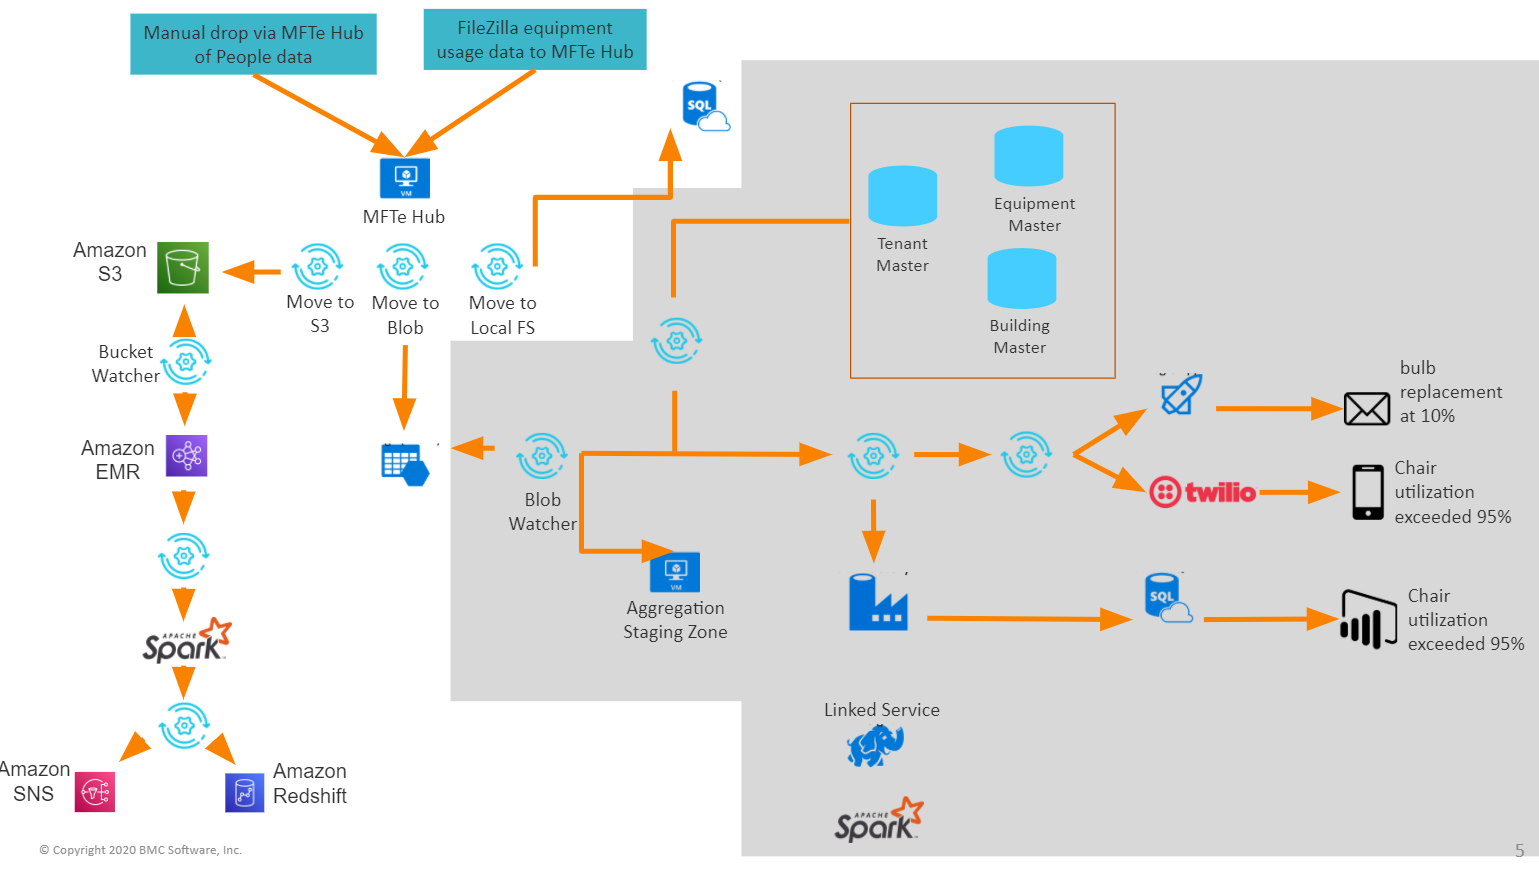

# Step 1 - Setup

## Step 1A - Install the library

In [ ]:
#!pip install git+https://github.com/controlm/ctm-python-client.git

## Step 1B- Import the library

In [ ]:
#from bmc_control_m import Control_M_Jobflow, DummyJob, CommandJob, , DatabaseSQLScript, EmbeddedScript
from ctm_python_client.core.bmc_control_m import CmJobFlow
from ctm_python_client.jobs.dummy import DummyJob
from ctm_python_client.jobs.command import CommandJob 
from ctm_python_client.jobs.database.sql_script import SQLScriptJob
from ctm_python_client.jobs.embedded_script import EmbeddedScriptJob


In [ ]:
#Define custom AI Job Type
from ctm_python_client.jobs.ai_jobs.ai_generic import AiGenericJob

class AIBlobStorageJob(AiGenericJob):
    def __init__(
        self,
        folder,
        job_name,
        connection_profile,
        ai_action,
        ai_blob_name,
        ai_container,
        ai_file_path,
        ai_public_access,
        host=None,
        run_as=None,
        description=None,
    ):
        params_dict = {
            "AI-Action" : ai_action,
            "AI-Blob name (Up/Download)" : ai_blob_name,
            "AI-Container (Up/Download)" : ai_container,
            "AI-File path" : ai_file_path,
            "AI-Public Access" : ai_public_access
        }

        AiGenericJob.__init__(self, folder=folder, job_name=job_name, 
            connection_profile=connection_profile,
            ai_name="AI Blob Storage", host=host, run_as=run_as, 
            description=description, **params_dict)

# Step 2 - Instantiate, Authenticate and Schedule


## Step 2A - Create the object

In [ ]:
t1_flow = CmJobFlow(application="Demo",sub_application="Demo-04",
                            description= "Build Control-M in Azure demo", order_method="Manual")

## Step 2B - Authenticate to Control-M

In [ ]:
# Create a file .secrets with the following three lines. One for uri, one for user and one for password.
"""
https://hostname:8443/automation-api
username
password
"""
import os
BASE_PATH = os.path.abspath("")
with open(BASE_PATH + "/.secrets", "r") as fp:
    ctm_uri = fp.readline().strip()
    ctm_user = fp.readline().strip()
    ctm_pwd = fp.readline().strip()

In [ ]:
from ctm_python_client.session.session import Session

session = Session(endpoint=ctm_uri, username=ctm_user, password=ctm_pwd)
session.get_token()

In [ ]:
t1_flow = CmJobFlow(
    application="Demo", sub_application="Demo-04", session=session,  ctm_uri=ctm_uri)

## Step 2C - Define the Flow Level Defaults

### Default RunAs and host

In [ ]:
t1_flow.set_run_as(username="ctmadmin",host="host")


### Define Default Schedule

In [ ]:
# Define the schedule
weekDays = ["ALL"]
t1_flow.set_schedule(week_days=weekDays)

# Step 3  - Create Folder

### Define Variables

In [ ]:
# Create Fodler
f1 = t1_flow.create_folder("SmartBuilding")


# Step 4 - Create Tasks

## Create Start and End Dummy Jobs

In [ ]:
start = t1_flow.add_job(f1, DummyJob(f1,"StartFlow"))
end = t1_flow.add_job(f1, DummyJob(f1,"EndFlow"))

## SMB_Update_demoparms

In [ ]:
SMB_Update_demoparms = CommandJob(f1, "SMB_Update_demoparms", 
            command =  "pwsh \"C:\\Production\\scripts\\sp_login.ps1\" -cf \"C:\\Production\\Data\\azcreds.txt\" -pf \"C:\\Production\\Data\\demo_parms.cfg\"",
	        pre_command = "echo pre_command & copy \"C:\\Production\\Demo_Templates\\demo_parms_Template.cfg\" \"C:\\Production\\Data\\demo_parms.cfg\""
)
SMB_Update_demoparms_id = t1_flow.add_job(f1, SMB_Update_demoparms)

## SMB_JarFile

In [ ]:
SMB_JarFile = AIBlobStorageJob(f1, "SMB_JarFile", connection_profile = "FY21DEMO",
            ai_action= "Upload", ai_blob_name="spark/jar/sblr.jar", 
                 ai_container="smartbuilding", ai_file_path="C:\\Production\\Data\\ADF_Artifacts\\sblr.jar",
                  ai_public_access = "Off")
SMB_JarFile_id = t1_flow.add_job(f1, SMB_JarFile)

## SMB_Create_files_notifications

In [ ]:
SMB_Create_files_notifications = AIBlobStorageJob(f1, "SMB_Create_files_notifications", connection_profile = "FY21DEMO",
            ai_action= "Upload", ai_blob_name="files/notifications/part-00000-8c6cbeb4-9b41-4201-abff-83d42b60aaca-c000.csv", 
                 ai_container="smartbuilding", ai_file_path="C:\\Production\\Data\\ADF_Artifacts\\buildingdata.csv",
                  ai_public_access = "Off")
SMB_Create_files_notifications_id = t1_flow.add_job(f1, SMB_Create_files_notifications)

## SMB_dirclean_pig_script

In [ ]:
SMB_dirclean_pig_script = AIBlobStorageJob(f1, "SMB_dirclean_pig_script", connection_profile = "FY21DEMO",
            ai_action= "Upload", ai_blob_name="spark/script/dir_clean.pig", 
                 ai_container="smartbuilding", ai_file_path="C:\\Production\\Data\\ADF_Artifacts\\dir_clean.pig",
                  ai_public_access = "Off")
SMB_dirclean_pig_script_id = t1_flow.add_job(f1, SMB_dirclean_pig_script)

## SMB_cleanNotifications_pig_script

In [ ]:
SMB_cleanNotifications_pig_script = AIBlobStorageJob(f1, "SMB_cleanNotifications_pig_script", connection_profile = "FY21DEMO",
            ai_action= "Upload", ai_blob_name="spark/script/dir_clean.pig", 
                 ai_container="smartbuilding", ai_file_path="C:\\Production\\Data\\ADF_Artifacts\\dir_clean.pig",
                  ai_public_access = "Off")
SMB_cleanNotifications_pig_script_id = t1_flow.add_job(f1, SMB_cleanNotifications_pig_script)

## SMB_Define_SQL_Table

In [ ]:
SMB_Define_SQL_Table = SQLScriptJob(f1, "SMB_Define_SQL_Table", connection_profile = "AZSQL",
            sql_script= "C:\\Production\\Data\\ADF_Artifacts\\CreateSBData.sql")
SMB_Define_SQL_Table_id = t1_flow.add_job(f1, SMB_Define_SQL_Table)

## SMB__Deploy_connection_profiles

In [ ]:
SMB__Deploy_connection_profiles = EmbeddedScriptJob(f1, "SMB__Deploy_connection_profiles", 
            script = "cmd /c ctm deploy C:\\Production\\JSON\\cp_ADF.json\\ncmd /c ctm deploy C:\\Production\\JSON\\cp_AZSQL.json\\ncmd /c ctm deploy c:\\Production\\JSON\\CP_FY21DEMO_BlobStg.json\\ncmd /c ctm deploy c:\\Production\\JSON\\cp_LogicApps.json",
            file_name = "cpdeploy.bat")
SMB__Deploy_connection_profiles_id = t1_flow.add_job(f1, SMB__Deploy_connection_profiles)

## Command Jobs

In [ ]:
SMB_Update_StgSQL_Parameters = CommandJob(f1,  "SMB_Update_StgSQL_Parameters",
			command = "pwsh \"C:\\Production\\scripts\\ReplaceMultiStrings.ps1\" -if \"C:\\Production\\Demo_Templates\\FY21Demo_stgDB050_parameters_Template.json\" -of \"C:\\Production\\ARM_Templates\\FY21Demo_stgDB050_parameters.json\" -kf \"C:\\Production\\Data\\demo_parms.cfg\""
			,pre_command = "del \"C:\\Production\\ARM_Templates\\FY21Demo_stgDB050_parameters.json\""
)
SMB_Update_StgSQL_Parameters_id =t1_flow.add_job(f1, SMB_Update_StgSQL_Parameters)

SMB_Update_PublicIP = CommandJob(f1,  "SMB_Update_PublicIP",
			command = "pwsh \"C:\\Production\\scripts\\AddPublicIp.ps1\" -of \"C:\\Production\\Data\\demo_parms.cfg\""
)
SMB_Update_PublicIP_id =t1_flow.add_job(f1, SMB_Update_PublicIP)

SMB_Update_PigScript_Parameters = CommandJob(f1,  "SMB_Update_PigScript_Parameters",
			command = "pwsh \"C:\\Production\\scripts\\ReplaceMultiStrings.ps1\" -if \"C:\\Production\\Demo_Templates\\clean_notifications_template.pig\" -of \"C:\\Production\\Data\\ADF_Artifacts\\clean_notifications.pig\" -kf \"C:\\Production\\Data\\demo_parms.cfg\""
			,pre_command = "del \"C:\\Production\\Data\\ADF_Artifacts\\clean_notifications.pig\""
)
SMB_Update_PigScript_Parameters_id =t1_flow.add_job(f1, SMB_Update_PigScript_Parameters)

SMB_Update_ADF_Parameters = CommandJob(f1,  "SMB_Update_ADF_Parameters",
			command = "pwsh \"C:\\Production\\scripts\\ReplaceMultiStrings.ps1\" -if \"C:\\Production\\Demo_Templates\\FY21Demo_ADF050_parameters_Template.json\" -of \"C:\\Production\\ARM_Templates\\FY21Demo_ADF050_parameters.json\" -kf \"C:\\Production\\Data\\demo_parms.cfg\""
			,pre_command = "del \"C:\\Production\\ARM_Templates\\FY21Demo_ADF050_parameters.json\""
)
SMB_Update_ADF_Parameters_id =t1_flow.add_job(f1, SMB_Update_ADF_Parameters)

SMB_Update_LA_Parameters = CommandJob(f1,  "SMB_Update_LA_Parameters",
			command = "pwsh \"C:\\Production\\scripts\\ReplaceMultiStrings.ps1\" -if \"C:\\Production\\Demo_Templates\\FY21Demo_LA010_parameters_Template.json\" -of \"C:\\Production\\ARM_Templates\\FY21Demo_LA010_parameters.json\" -kf \"C:\\Production\\Data\\demo_parms.cfg\""
			,pre_command = "del \"C:\\Production\\ARM_Templates\\FY21Demo_LA010_parameters.json\""
)
SMB_Update_LA_Parameters_id =t1_flow.add_job(f1, SMB_Update_LA_Parameters)

SMB_Update_ADF_CP = CommandJob(f1,  "SMB_Update_ADF_CP",
			command = "pwsh \"C:\\Production\\scripts\\ReplaceMultiStrings.ps1\" -if \"C:\\Production\\Demo_Templates\\cp_ADF_Template.json\" -of \"C:\\Production\\JSON\\cp_ADF.json\" -kf \"C:\\Production\\Data\\demo_parms.cfg\""
			,pre_command = "del \"C:\\Production\\JSON\\cp_ADF.json\""
)
SMB_Update_ADF_CP_id =t1_flow.add_job(f1, SMB_Update_ADF_CP)

SMB_Update_AZSQL_CP = CommandJob(f1,  "SMB_Update_AZSQL_CP",
			command = "pwsh \"C:\\Production\\scripts\\ReplaceMultiStrings.ps1\" -if \"C:\\Production\\Demo_Templates\\cp_AZSQL_template.json\" -of \"C:\\Production\\JSON\\cp_AZSQL.json\" -kf \"C:\\Production\\Data\\demo_parms.cfg\""
			,pre_command = "del \"C:\\Production\\JSON\\cp_AZSQL.json\""
)
SMB_Update_AZSQL_CP_id =t1_flow.add_job(f1, SMB_Update_AZSQL_CP)

SMB_Update_BlobStg_CP = CommandJob(f1,  "SMB_Update_BlobStg_CP",
			command = "pwsh \"C:\\Production\\scripts\\ReplaceMultiStrings.ps1\" -if \"C:\\Production\\Demo_Templates\\CP_FY21DEMO_BlobStg_template.json\" -of \"C:\\Production\\JSON\\CP_FY21DEMO_BlobStg.json\" -kf \"C:\\Production\\Data\\demo_parms.cfg\""
			,pre_command = "del \"C:\\Production\\JSON\\CP_FY21DEMO_BlobStg.json\""
)
SMB_Update_BlobStg_CP_id =t1_flow.add_job(f1, SMB_Update_BlobStg_CP)

SMB_Update_LogicApps_CP = CommandJob(f1,  "SMB_Update_LogicApps_CP",
			command = "pwsh \"C:\\Production\\scripts\\ReplaceMultiStrings.ps1\" -if \"C:\\Production\\Demo_Templates\\cp_LogicApps_Template.json\" -of \"C:\\Production\\JSON\\cp_LogicApps.json\" -kf \"C:\\Production\\Data\\demo_parms.cfg\""
			,pre_command = "del \"C:\\Production\\JSON\\cp_LogicApps.json\""
)
SMB_Update_LogicApps_CP_id =t1_flow.add_job(f1, SMB_Update_LogicApps_CP)

SMB_Deploy_StgSql = CommandJob(f1,  "SMB_Deploy_StgSql",
			command = "pwsh \"C:\\Production\\scripts\\PrepForDemoDeployment.ps1\" -t \"C:\\Production\\ARM_Templates\\FY21Demo_stgDB050_Template.json\" -p \"C:\\Production\\ARM_Templates\\FY21Demo_stgDB050_parameters.json\" -cf \"C:\\Production\\Data\\azcreds.txt\" -of \"C:\\Production\\Data\\demo_parms.cfg\""
)
SMB_Deploy_StgSql_id =t1_flow.add_job(f1, SMB_Deploy_StgSql)

SMB_Deploy_ADF = CommandJob(f1,  "SMB_Deploy_ADF",
			command = "pwsh \"C:\\Production\\scripts\\DeployDataFactory.ps1\" -t \"C:\\Production\\ARM_Templates\\FY21Demo_ADF050_Template.json\" -p \"C:\\Production\\ARM_Templates\\FY21Demo_ADF050_parameters.json\" -cf \"C:\\Production\\Data\\azcreds.txt\" -of \"C:\\Production\\Data\\demo_parms.cfg\""
)
SMB_Deploy_ADF_id =t1_flow.add_job(f1, SMB_Deploy_ADF)

SMB_Deploy_API_Connection = CommandJob(f1,  "SMB_Deploy_API_Connection",
			command = "pwsh \"C:\\Production\\scripts\\DeployARM_Template.ps1\" -t \"C:\\Production\\ARM_Templates\\FY21Demo_Mail000_Template.json\" -p none -cf \"C:\\Production\\Data\\azcreds.txt\""
)
SMB_Deploy_API_Connection_id =t1_flow.add_job(f1, SMB_Deploy_API_Connection)

SMB_Deploy_LogicApp = CommandJob(f1,  "SMB_Deploy_LogicApp",
			command = "pwsh \"C:\\Production\\scripts\\DeployARM_Template.ps1\" -t \"C:\\Production\\ARM_Templates\\FY21Demo_LA010_Template.json\" -p \"C:\\Production\\ARM_Templates\\FY21Demo_LA010_parameters.json\" -cf \"C:\\Production\\Data\\azcreds.txt\""
)
SMB_Deploy_LogicApp_id =t1_flow.add_job(f1, SMB_Deploy_LogicApp)


# Step 5 - Chain Tasks

In [ ]:
t1_flow.chain_jobs(f1,[start, SMB_Update_demoparms_id,SMB_Update_PublicIP_id,SMB_Update_StgSQL_Parameters_id,SMB_Deploy_StgSql_id])
t1_flow.chain_jobs(f1,[SMB_Deploy_StgSql_id,SMB_Update_ADF_CP_id,SMB__Deploy_connection_profiles_id])
t1_flow.chain_jobs(f1,[SMB_Deploy_StgSql_id,SMB_Update_AZSQL_CP_id,SMB__Deploy_connection_profiles_id])
t1_flow.chain_jobs(f1,[SMB_Deploy_StgSql_id,SMB_Update_BlobStg_CP_id,SMB__Deploy_connection_profiles_id])
t1_flow.chain_jobs(f1,[SMB_Deploy_StgSql_id,SMB_Update_LogicApps_CP_id,SMB__Deploy_connection_profiles_id])
t1_flow.chain_jobs(f1,[SMB__Deploy_connection_profiles_id,SMB_Define_SQL_Table_id,SMB_Deploy_ADF_id, end])
t1_flow.chain_jobs(f1,[SMB__Deploy_connection_profiles_id,SMB_Deploy_ADF_id])
t1_flow.chain_jobs(f1,[SMB__Deploy_connection_profiles_id,SMB_JarFile_id,SMB_Deploy_ADF_id])
t1_flow.chain_jobs(f1,[SMB__Deploy_connection_profiles_id,SMB_dirclean_pig_script_id,SMB_Deploy_ADF_id])
t1_flow.chain_jobs(f1,[SMB__Deploy_connection_profiles_id,SMB_Update_PigScript_Parameters_id,SMB_cleanNotifications_pig_script_id,SMB_Deploy_ADF_id])
t1_flow.chain_jobs(f1,[SMB__Deploy_connection_profiles_id,SMB_Update_ADF_Parameters_id,SMB_Deploy_ADF_id])
t1_flow.chain_jobs(f1,[SMB_Create_files_notifications_id,SMB_Deploy_ADF_id])
t1_flow.chain_jobs(f1,[SMB__Deploy_connection_profiles_id,SMB_Create_files_notifications_id,SMB_Deploy_API_Connection_id,SMB_Update_LA_Parameters_id,SMB_Deploy_LogicApp_id, end])

# Step 6 - Display Workflow

## Step 6A - Display DAG

In [ ]:
# display using graphviz
from ctm_python_client.utils.displayDAG import DisplayDAG

# sudo apt-get install graphviz (on unix)
#  or
# brew install graphviz (for mac)
DisplayDAG(t1_flow).display_graphviz()

## Step 6B - Display JSON

In [ ]:
t1_flow.display_json()

# Step 7 - Submit Workflow to Control-M

In [ ]:
t1_flow.deploy()